In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import statsmodels.api as sm

In [3]:
data = pd.read_csv('data/Wage.csv', index_col=0).reset_index(drop=True)
data

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [6]:
x = data['age']
X = x.values.reshape(-1,1)
y = data['wage']

## Polynominal Regression

In [10]:
mse = pd.Series([])
cv = KFold(n_splits=10, random_state=None, shuffle=False)
for i in range(1,8):
    X_current = PolynomialFeatures(i).fit_transform(X)
    lm = LinearRegression()
    score = cross_val_score(lm, X_current, y, cv=cv, scoring='neg_mean_squared_error')
    mse.loc[i] = np.mean(np.abs(score))
mse
# The optional degree d is 4, with have lowest MSE when use cross-validation method

1    1675.674250
2    1600.326984
3    1595.311575
4    1593.935656
5    1594.479552
6    1594.064846
7    1595.549886
dtype: float64

In [16]:
# Process ANOVA test
X1 = PolynomialFeatures(1).fit_transform(X)
X2 = PolynomialFeatures(2).fit_transform(X)
X3 = PolynomialFeatures(3).fit_transform(X)
X4 = PolynomialFeatures(4).fit_transform(X)
X5 = PolynomialFeatures(5).fit_transform(X)

poly_1 = sm.GLS(y, X1).fit()
poly_2 = sm.GLS(y, X2).fit()
poly_3 = sm.GLS(y, X3).fit()
poly_4 = sm.GLS(y, X4).fit()
poly_5 = sm.GLS(y, X5).fit()

anova_poly = sm.stats.anova_lm(poly_1, poly_2, poly_3, poly_4, poly_5)
print(anova_poly)
# Follow Anova test, best option is poly_4 with degree 4
# Same result as Cross-validation method

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


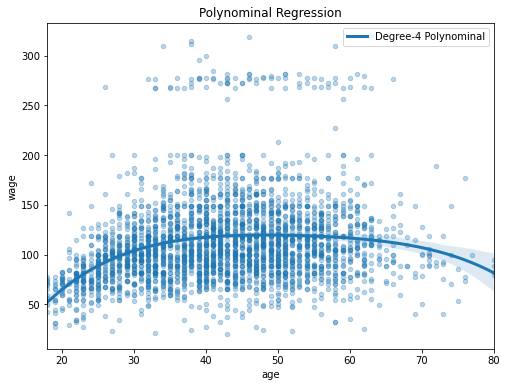

In [26]:
plt.figure(figsize=(8,6))
sb.regplot(data=data, x='age', y='wage', order=4, scatter_kws={"s": 20, 'alpha': 0.3}, line_kws={'linewidth': 3, 'label': 'Degree-4 Polynominal'})
# sb.regplot(data=data, x='age', y='wage', scatter=False, order=1, ci=None, line_kws={'linewidth': 3}, label='Linear Regression')
# sb.regplot(data=data, x='age', y='wage', scatter=False, order=2, ci=None, line_kws={'linewidth': 3}, label='Degree-2 Polynominal')
# sb.regplot(data=data, x='age', y='wage', scatter=False, order=3, ci=None, line_kws={'linewidth': 3}, label='Degree-3 Polynominal')
# sb.regplot(data=data, x='age', y='wage', scatter=False, order=5, ci=None, line_kws={'linewidth': 3}, label='Degree-5 Polynominal')
plt.legend()
plt.title('Polynominal Regression')
plt.show()

## Step Function

In [63]:
mse = pd.Series([])
cv = KFold(n_splits=10, random_state=None, shuffle=False)

for i in range(2,21):
    # Cut X in some bins to plot step constant method
    df_cut, bins = pd.cut(data['age'], i, retbins=True, right=True)

    # Create dummy variables for the age groups
    df_steps_dummies = pd.get_dummies(df_cut, drop_first=True)

    # Create scoring function
    lm = LinearRegression()
    score = cross_val_score(lm, df_steps_dummies, y, cv=cv, scoring='neg_mean_squared_error')

    # Add result mean to mse
    mse.loc[i] = np.mean(np.abs(score))
mse
# Optimal number of cuts is 16, which have min mse

2     1733.624765
3     1682.924819
4     1635.290418
5     1631.855269
6     1623.656547
7     1611.416931
8     1600.011094
9     1611.119883
10    1605.608774
11    1601.164315
12    1604.253313
13    1600.760190
14    1605.262605
15    1605.720590
16    1595.635031
17    1606.517304
18    1603.312947
19    1603.040776
20    1605.328323
dtype: float64

In [61]:
# Cut X in some bins to plot step constant method
df_cut, bins = pd.cut(data['age'], 16, retbins=True, right=True)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_cut, drop_first=True)

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

# Create step model
poly_step_model = sm.GLM(y, df_steps_dummies).fit()
print(poly_step_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2984
Model Family:                Gaussian   Df Model:                           15
Link Function:               identity   Scale:                          1592.2
Method:                          IRLS   Log-Likelihood:                -15308.
Date:                Thu, 22 Oct 2020   Deviance:                   4.7510e+06
Time:                        01:44:50   Pearson chi2:                 4.75e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              66.4094      5.151     

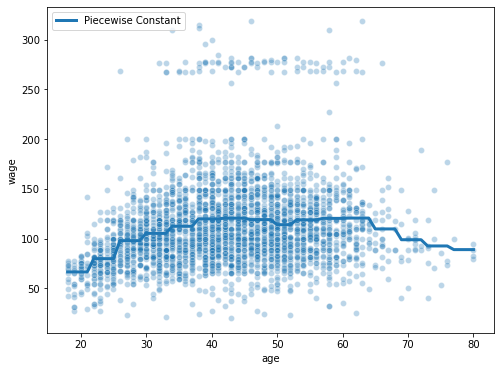

In [62]:
# Create x_range follow bins
x_range = np.arange(x.min(), x.max()+1).reshape(-1,1)
x_range_bins = np.digitize(x_range.ravel(), bins, right=True)
x_range_bins = pd.get_dummies(x_range_bins, drop_first=True)
x_range_bins = sm.add_constant(x_range_bins)

# y_visual_step
y_visual_step = poly_step_model.predict(x_range_bins)

# Visualize step constant function
plt.figure(figsize=(8,6))
sb.scatterplot(data=data, x='age', y='wage', alpha=0.3)
plt.plot(x_range, y_visual_step, linewidth=3, label='Piecewise Constant')
plt.legend()
plt.show()